<a href="https://colab.research.google.com/github/gitamgadtaula/F_S_E_C/blob/fsec/ARIMAx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 25 16:48:15 2019

@author: nageshsinghchauhan
"""

import os
import warnings
!pip install pmdarima
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np



dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
raw_data = pd.read_csv("/content/drive/MyDrive/thesis dataset/ntc_monthly.csv")
raw_data.columns = raw_data.columns.str.title()
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
# data=raw_data
data=raw_data.iloc[::-1]



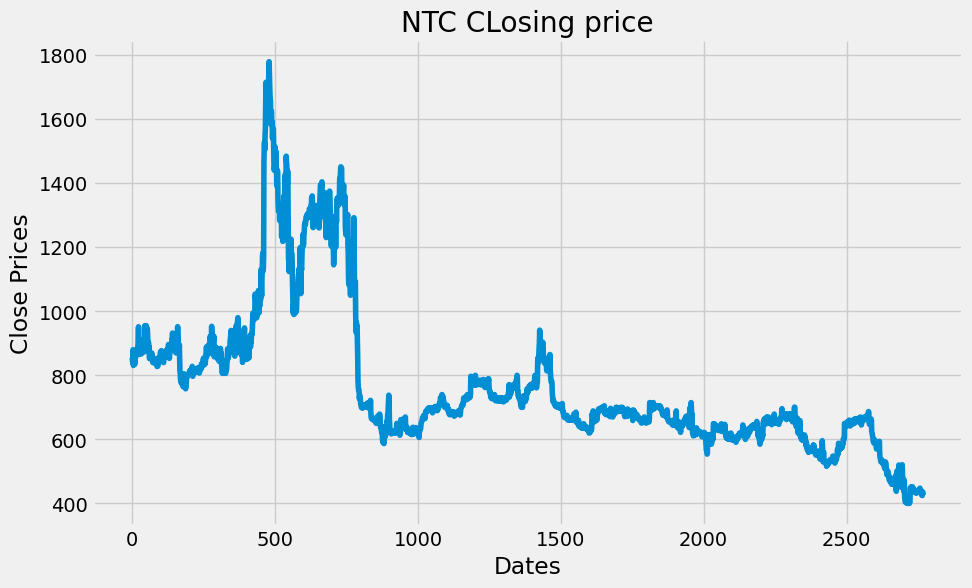

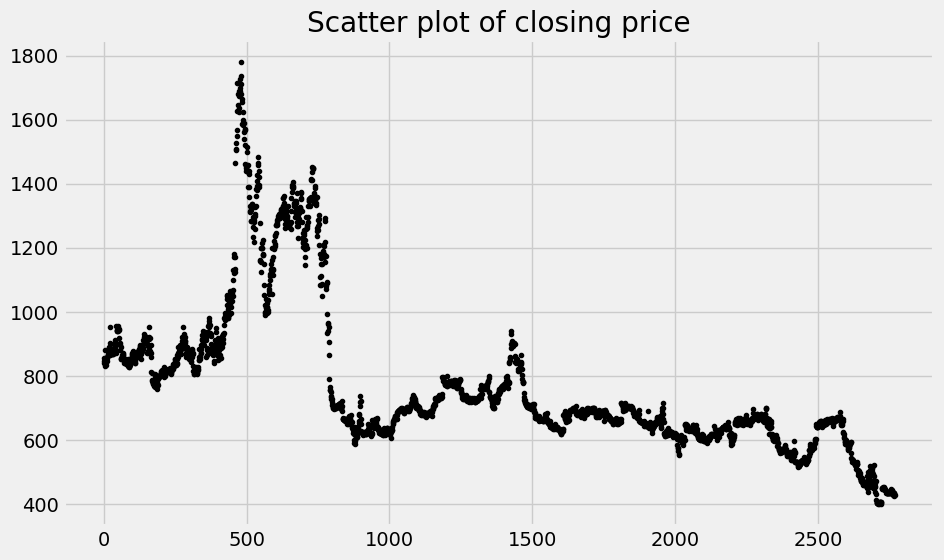

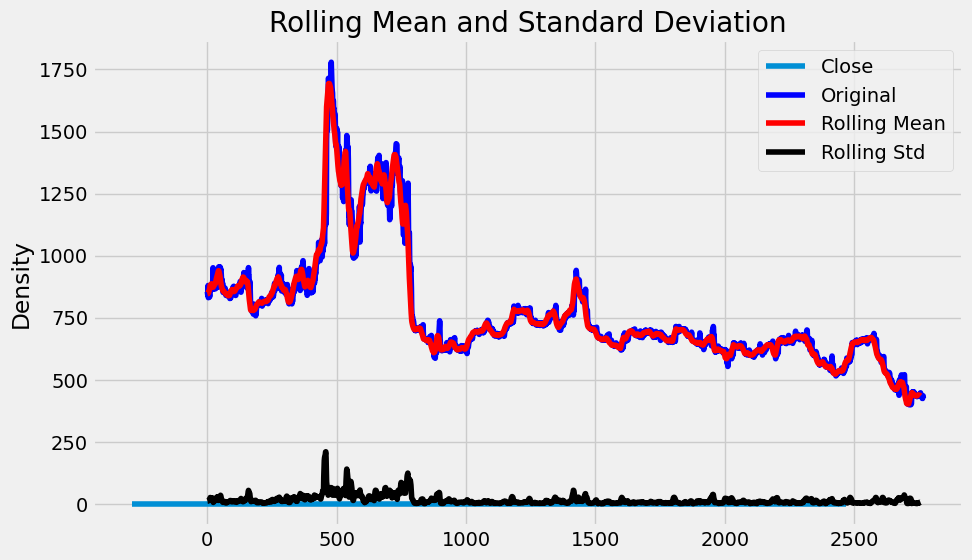

Results of dickey fuller test
Test Statistics                  -2.543427
p-value                           0.105262
No. of lags used                 14.000000
Number of observations used    2754.000000
critical value (1%)              -3.432727
critical value (5%)              -2.862590
critical value (10%)             -2.567329
dtype: float64


<Figure size 1000x600 with 0 Axes>

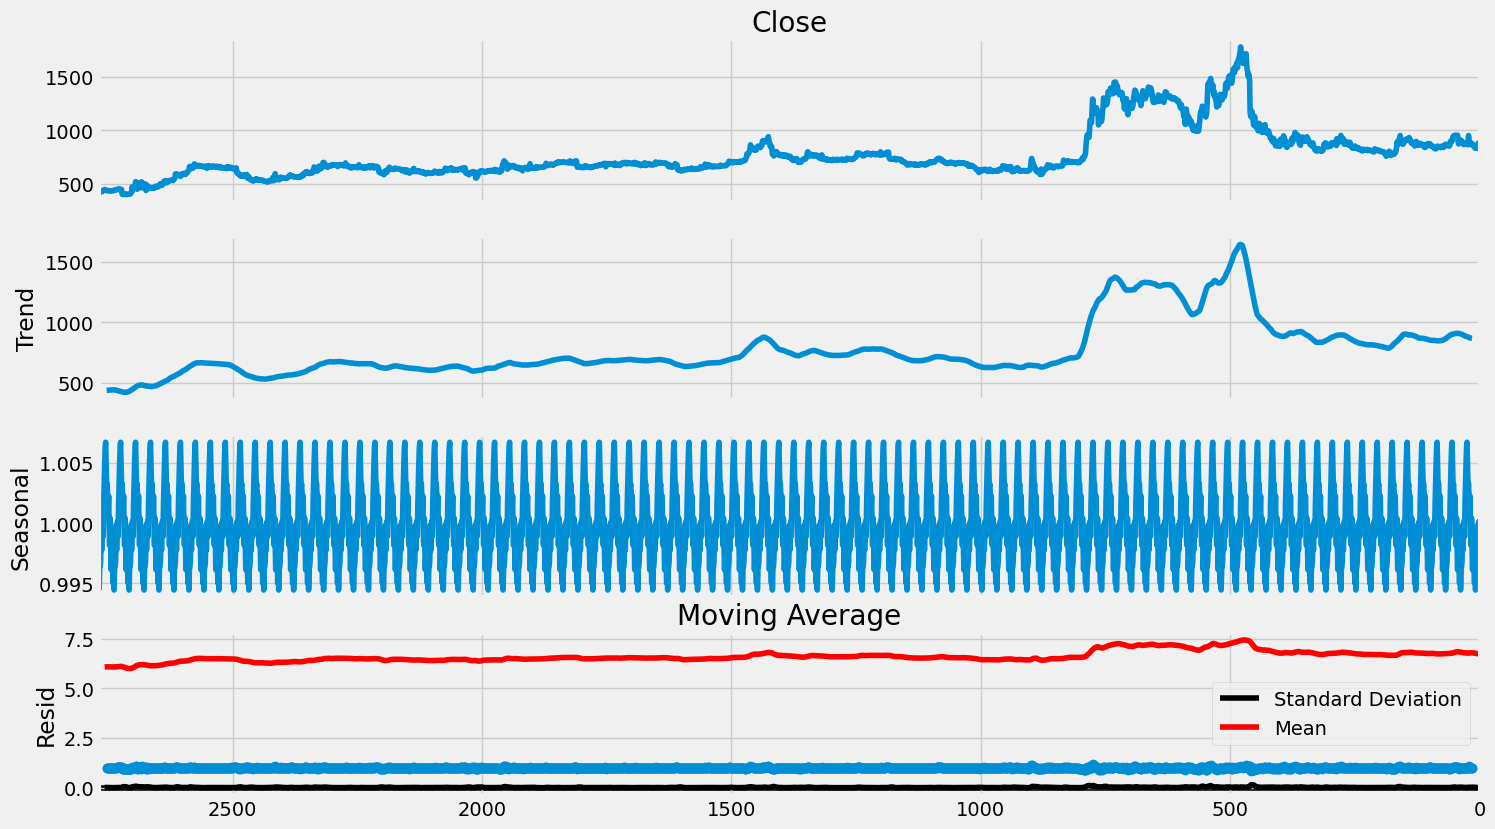

In [204]:

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('NTC CLosing price')
plt.show()

#scatter plot of the sales
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

#Distribution of the dataset
df_close.plot(kind='kde')
#We can observe a near-normal distribution(bell-curve) over sales values.

#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)


#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# Taking the logarithm of the closing prices before fitting the model
df_log = np.log(df_close)
# df_log = (df_close)

moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()



In [199]:
df_log.tail(5)

4    831.0
3    880.0
2    840.0
1    845.0
0    855.0
Name: Close, dtype: float64

In [205]:
import statsmodels.api as smapi

#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
test_dates = data['Date'][int(len(data) * 0.9):]


# plt.figure(figsize=(10,6))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Closing Prices')
# plt.plot(df_log, 'green', label='Train data')
# plt.plot(test_data, 'blue', label='Test data')
# plt.legend()


print(test_data)



276    6.819907
275    6.800170
274    6.813445
273    6.826545
272    6.785588
         ...   
4      6.722630
3      6.779922
2      6.733402
1      6.739337
0      6.751101
Name: Close, Length: 277, dtype: float64


In [206]:
# using Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

#The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

#The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                      max_d=3, max_p=5, max_q=5, seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_autoARIMA.summary())

print("Auto-ARIMA Model Order:", model_autoARIMA.order)

p = model_autoARIMA.order[0]
d = model_autoARIMA.order[1]
q = model_autoARIMA.order[2]

# print("p:", p)
# print("d:", d)
# print("q:", q)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12742.548, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12746.459, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12744.559, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12744.584, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12747.822, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.200 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2492
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6374.911
Date:                Thu, 28 Mar 2024   AIC                         -12747.822
Time:                        08:38:19   BIC                         -12742.002
Sample:                             0   HQIC                        -12745.709
                               - 2492                             

In [207]:
# Build ARIMAX Model
model = smapi.tsa.arima.ARIMA(train_data, order=(0,1,0))
fitted = model.fit()
# print(fitted.summary())


MAE: 0.05946126776220583
RMSE: 0.07201074740756236
MAPE: 0.8849215168245426%


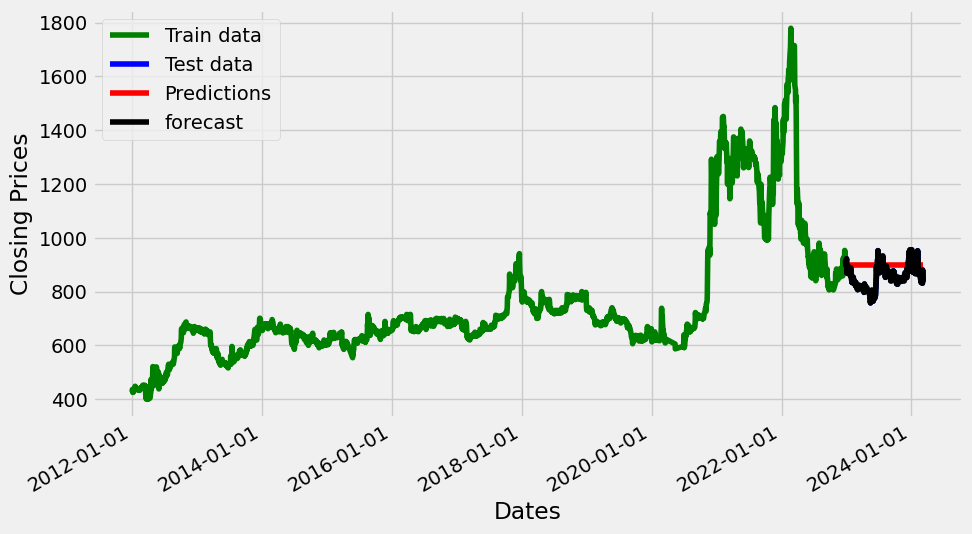

In [212]:
import matplotlib.dates as mdates
# Generate predictions
predictions = fitted.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
# Calculate evaluation metrics
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

forecast=fitted.forecast(len(test_data))
predictions_original_scale = np.exp(predictions)
test_original_scale=np.exp(test_data)
forecast_original_scale=np.exp(test_data)



# Print the results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

# Plot the predictions
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')

# plt.plot(df_log,label='Acutal')
# plt.plot(test_data,label='test')
# plt.plot(predictions,label='predictions')

# Plotting the original scale predictions and CIs
plt.plot(data['Date'], data['Close'], 'green', label='Train data')
plt.plot(test_dates, test_original_scale, 'blue', label='Test data')
plt.plot(test_dates, predictions_original_scale, 'red', label='Predictions')
plt.plot(test_dates, forecast_original_scale, 'black', label='forecast')

date_form = mdates.DateFormatter("%Y-%m-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()